In [1]:
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

for i in [pd, np, mpl, sns]:
    print(i.__name__, i.__version__)

pandas 2.2.0
numpy 1.26.4
matplotlib 3.9.4
seaborn 0.13.2


# 1-4 데이터 시각화

-  패턴 및 관계 파악, 효과적인 의사 소통

1. 추세 및 패턴 시각화


2. 이상치 탐지


3. 시각화를 통한 변수간 관계 파악

## 0. 데이터셋 소개

### Space Titanic

|variable name|description|
|---|:---|
|PassengerId|A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.|
|HomePlanet|The planet the passenger departed from, typically their planet of permanent residence.|
|CryoSleep|Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.|
|Cabin|The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.|
|Destination|The planet the passenger will be debarking to.|
|Age|The age of the passenger.|
|VIP|Whether the passenger has paid for special VIP service during the voyage.|
|RoomService, FoodCourt, ShoppingMall, Spa, VRDeck| Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.|
|Name|The first and last names of the passenger.|
|Transported|Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.|

In [2]:
df_space = pd.read_csv('data/space_titanic.csv', index_col='PassengerId')
df_space.head()

HomePlanet CryoSleep  Cabin  Destination   Age    VIP  \
PassengerId                                                         
0001_01         Europa     False  B/0/P  TRAPPIST-1e  39.0  False   
0002_01          Earth     False  F/0/S  TRAPPIST-1e  24.0  False   
0003_01         Europa     False  A/0/S  TRAPPIST-1e  58.0   True   
0003_02         Europa     False  A/0/S  TRAPPIST-1e  33.0  False   
0004_01          Earth     False  F/1/S  TRAPPIST-1e  16.0  False   

             RoomService  FoodCourt  ShoppingMall     Spa  VRDeck  \
PassengerId                                                         
0001_01              0.0        0.0           0.0     0.0     0.0   
0002_01            109.0        9.0          25.0   549.0    44.0   
0003_01             43.0     3576.0           0.0  6715.0    49.0   
0003_02              0.0     1283.0         371.0  3329.0   193.0   
0004_01            303.0       70.0         151.0   565.0     2.0   

                          Name  Transported  
PassengerId                                  
0001_01        Maham Ofracculy        False  
0002_01           Juanna Vines         True  
0003_01          Altark Susent        False  
0003_02           Solam Susent        False  
0004_01      Willy Santantines         True

## 데이터 전처리


1. PassengerID를 '\_'로 나누어 첫번째 변수는 PassengerGrp, 두 번째는 'GrpNo'로 추가합니다.


2. GrpNo는 정수형으로 형변환 합니다.

In [3]:
# pd.Series.str.split에서 expand=True로 설정하면 분리된 문자열들을 리스트에 모아 저장하지 않고, 
# 순서에 따라 컬럼으로 분리해서 뽑아냅니다.
df_space = pd.concat([
    df_space,
    df_space.index.to_frame()['PassengerId'].str.split('_', expand=True).rename( 
        columns={0: 'PassengerGrp', 1: 'GrpNo'}
    ).assign(
        GrpNo = lambda x: x['GrpNo'].astype(int)
    ),
], axis=1)

# 규원생각..: 아래와 같이 하면 훨씬 간단한 것을 ChatGPT를 통해 찾아봤다...
# # PassengerId 열을 '_'를 기준으로 분리하여 두 개의 새로운 열로 DataFrame에 바로 추가
# df_space[['PassengerGrp', 'GrpNo']] = df_space['PassengerId'].str.split('_', expand=True)
# # GrpNo 열의 데이터 타입을 정수형으로 변환
# df_space['GrpNo'] = df_space['GrpNo'].astype(int)

In [4]:
df_space.head()

HomePlanet CryoSleep  Cabin  Destination   Age    VIP  \
PassengerId                                                         
0001_01         Europa     False  B/0/P  TRAPPIST-1e  39.0  False   
0002_01          Earth     False  F/0/S  TRAPPIST-1e  24.0  False   
0003_01         Europa     False  A/0/S  TRAPPIST-1e  58.0   True   
0003_02         Europa     False  A/0/S  TRAPPIST-1e  33.0  False   
0004_01          Earth     False  F/1/S  TRAPPIST-1e  16.0  False   

             RoomService  FoodCourt  ShoppingMall     Spa  VRDeck  \
PassengerId                                                         
0001_01              0.0        0.0           0.0     0.0     0.0   
0002_01            109.0        9.0          25.0   549.0    44.0   
0003_01             43.0     3576.0           0.0  6715.0    49.0   
0003_02              0.0     1283.0         371.0  3329.0   193.0   
0004_01            303.0       70.0         151.0   565.0     2.0   

                          Name  Transported PassengerGrp  GrpNo  
PassengerId                                                      
0001_01        Maham Ofracculy        False         0001      1  
0002_01           Juanna Vines         True         0002      1  
0003_01          Altark Susent        False         0003      1  
0003_02           Solam Susent        False         0003      2  
0004_01      Willy Santantines         True         0004      1

## 1. 바이올린 플롯(Viloin Plot)

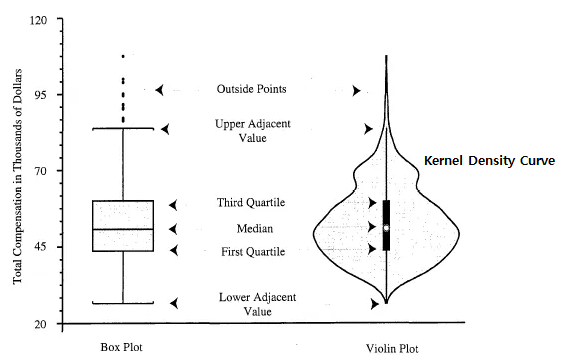

이미지 출처: [Violin plots explained](https://towardsdatascience.com/violin-plots-explained-fb1d115e023d)

### 특징

1. 연속형 데이터의 분포와 사분위 통계 정보를 출력합니다.

<div style="border: 0px solid #ddd; padding: 12px;">
    
- 박스 플롯과 커널 밀도 플롯이 결합한 형태의 출력물을 제공합니다.

</div>

2. 범주형 데이터와 결합하여 차트를 구성할 수 있습니다.

<div style="border: 0px solid #ddd; padding: 12px;">

- 이진형 변수와 결합하여 중심축을 기준으로 좌우를 구분하여 나타낼 수 있습니다.


-  범주형 변수를 축에 포함시켜, 수준별 바이올린 차트를 출력하도록 구성할 수 있습니다.
    
</div>

**[Ex.1]** 

<div style="border: 1px solid #ddd; padding: 12px; margin-top: 10px;">

df_space의 Age를 바이올린 플롯으로 출력합니다.
    
</div>

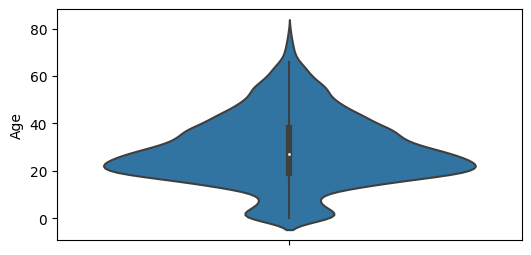

In [5]:
plt.figure(figsize=(6, 3))
sns.violinplot(data=df_space, y='Age')
plt.show()

**[Ex.2]** 

<div style="border: 1px solid #ddd; padding: 12px; margin-top: 10px;">

df_space에서 중심축 좌우를 Transported로 구분하고 x축은 HomePlanet으로, y축은 Age로 하여 바이올린 플롯으로 출력합니다.
    
</div>

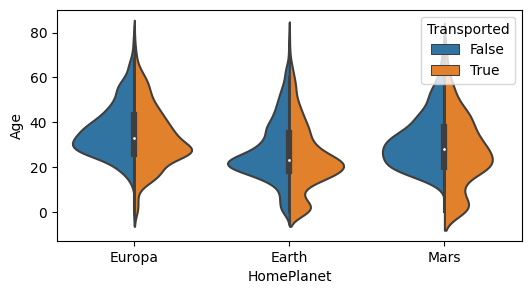

In [6]:
plt.figure(figsize=(6, 3))
sns.violinplot(data=df_space, x='HomePlanet', y='Age', split=True, hue='Transported')
plt.show()

## 2. 줄기 잎 플롯 (Stem and Leaf Plot)

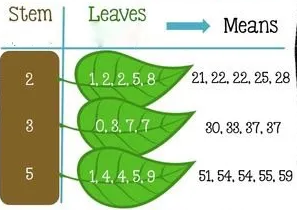

이미지 출처: [Stem and Leaf Plot — The Tree of Visualization.](https://cskoushik00.medium.com/stem-and-leaf-plot-the-tree-of-visualization-de451eb430c7)

### 특징

- 데이터의 분포와 동시에 상세 값을 표시할 수 있습니다.

**[Ex.3]** 

<div style="border: 1px solid #ddd; padding: 12px; margin-top: 10px;">

Stem and Leaf Plot을 이용하여 다음 데이터를 출력해봅니다.

```
data = np.array([21, 22, 22, 25, 28, 30, 33, 37, 37, 51, 54, 54, 55, 59])
```
    
</div>

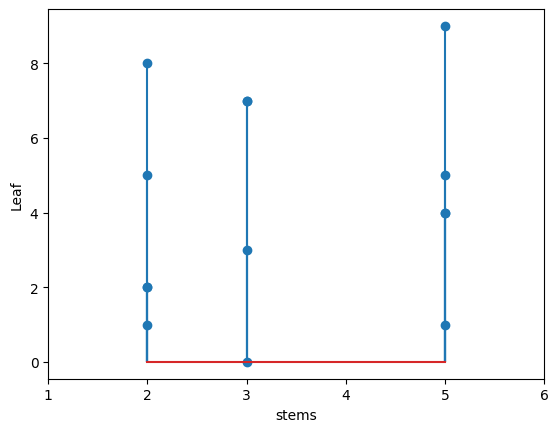

In [7]:
data = np.array([21, 22, 22, 25, 28, 30, 33, 37, 37, 51, 54, 54, 55, 59])
stems = data // 10
  
plt.ylabel('Leaf')
plt.xlabel('stems') 
plt.xlim(1, 6) 
  
plt.stem(
    data // 10, # Stem 
    data % 10, # Leaf
)
plt.show()

## 평행 좌표 그림 (Parallel Coordinates)

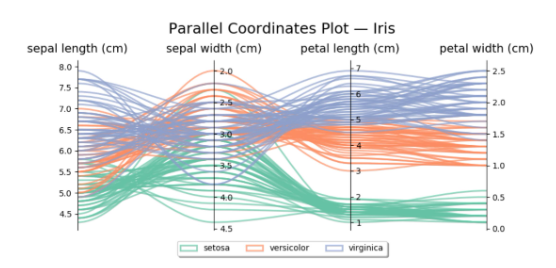

### 특징

1. 다차원 데이터의 패턴이나 군집을 직관적으로 보여줍니다.

<div style="border: 0px solid #ddd; padding: 12px;">

-  변수는 수직선으로 표현이 되고, 값은 수직선 위에 점으로 표시합니다.


-  동일 레코드에 수직선에 표시된 이웃점들을 선으로 연결하여 표시합니다.


-  색상이나 점의 모양으로 표본의 소속 군집을 표현합니다.

</div>

2. 데이터가 너무 많으면 지나치게 많은 선들이 겹쳐지게 되어 파악이 어려워집니다.


3. 효과적인 출력을 위한 변수의 출력 순서를 정하기 어렵습니다.

**[Ex.4]** 

<div style="border: 1px solid #ddd; padding: 12px; margin-top: 10px;">

CryoSleep이 False인 행들에서 PassengerGrp과 HomePlanet별로 RoomService, FoodCourt, ShoppingMall, Spa, VRDeck의 합계를 내어 df_spend 데이터프레임을 만듭니다. 

RoomService와 FoodCourt, ShoppingMall, Spa, VRDeck을 $log(X + 1)$ 변환하여, 변수의 폭을 줄여서 그래프로 출력이 용이하도록 합니다.

HomePlanet 별로 색상을 구분한 Parellel Coordindates를 출력합니다.
    
</div>

In [8]:
spend_cols = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

df_spend = df_space.loc[df_space['CryoSleep'] == False]\
    .groupby(['PassengerGrp', 'HomePlanet'], as_index=False)[spend_cols].sum()

df_spend[spend_cols] = np.log(df_spend[spend_cols] + 1)

df_spend

PassengerGrp HomePlanet  RoomService  FoodCourt  ShoppingMall       Spa  \
0            0001     Europa     0.000000   0.000000      0.000000  0.000000   
1            0002      Earth     4.700480   2.302585      3.258097  6.309918   
2            0003     Europa     3.784190   8.488794      5.918894  9.214830   
3            0004      Earth     5.717028   4.262680      5.023881  6.338594   
4            0005      Earth     0.000000   6.182085      0.000000  5.676754   
...           ...        ...          ...        ...           ...       ...   
4349         9272      Earth     5.789960   5.505332      6.492240  5.342334   
4350         9275     Europa     0.693147   7.044905      0.000000  3.931826   
4351         9276     Europa     0.000000   8.827615      0.000000  7.404888   
4352         9279      Earth     0.000000   0.000000      7.535297  0.693147   
4353         9280     Europa     4.844187   8.654866      0.000000  5.869297   

        VRDeck  
0     0.000000  
1     3.806662  
2     5.493061  
3     1.098612  
4     0.000000  
...        ...  
4349  5.799093  
4350  3.555348  
4351  4.317488  
4352  0.000000  
4353  8.085795  

[4354 rows x 7 columns]

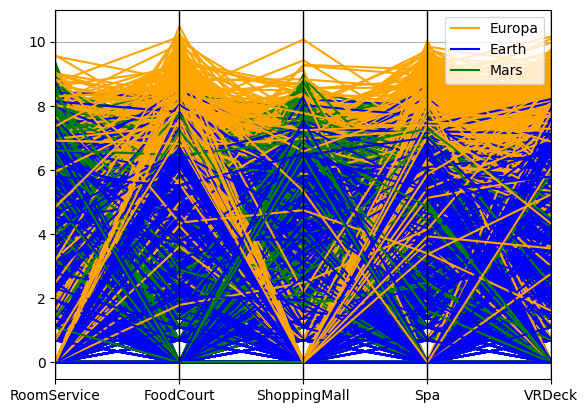

In [9]:
pd.plotting.parallel_coordinates(df_spend, 'HomePlanet', spend_cols, color=['orange', 'blue', 'green'])
plt.show()

**[Ex.5]** 

<div style="border: 1px solid #ddd; padding: 12px; margin-top: 10px;">

HomePlanet 별로 20개의 표본을 뽑아 출력해 봅니다.
    
</div>

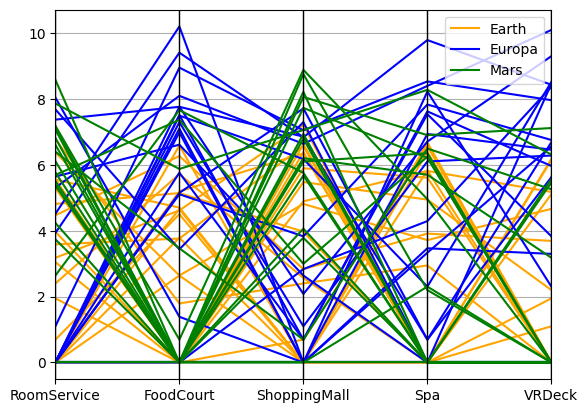

In [10]:
pd.plotting.parallel_coordinates(
    df_spend.groupby('HomePlanet', as_index=False).apply(lambda x: x.sample(n=20, random_state=123)), 
    'HomePlanet', spend_cols, color=['orange', 'blue', 'green']
)

plt.show()